<a href="https://colab.research.google.com/github/pimanzi/sentiment_analysis/blob/main/sentiment_analysis_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Import necessary libraries
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression

In [2]:

# Download latest version via kaggle hub
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [3]:
# Loading IMDB dataset
imdb_csv= f'{path}/IMDB Dataset.csv'
data = pd.read_csv(imdb_csv)



In [4]:
# Display the  few rows of the dataset
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#Exploratory Data Analysis (EDA)

/tmp/ipython-input-2721106937.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="sentiment", palette="Set2")


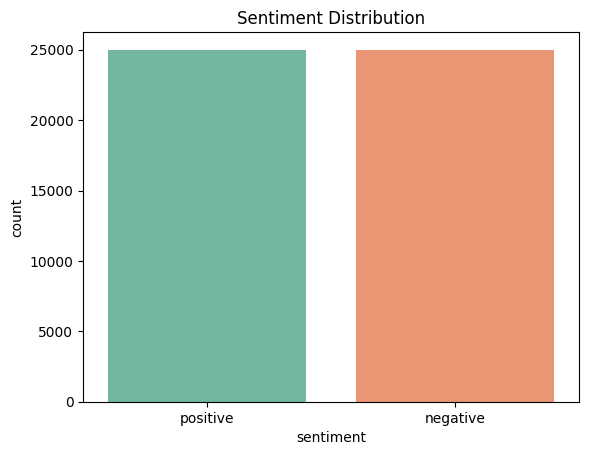

In [ ]:
# checking class distribution

sns.countplot(data=data, x="sentiment", palette="Set2")
plt.title("Sentiment Distribution")
plt.show()

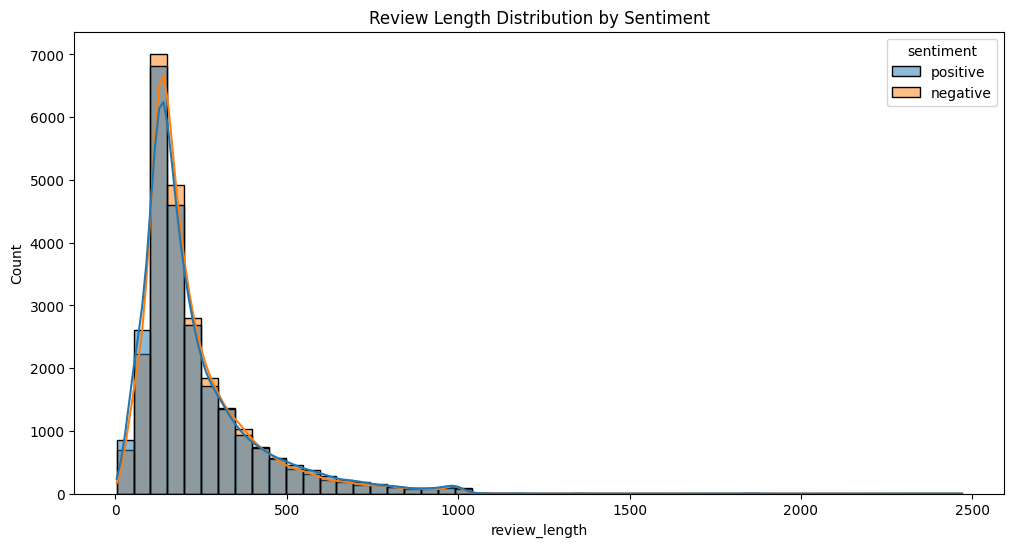

In [ ]:
# length distribution in both positive and negative reviews
data_copy= data.copy()
data_copy["review_length"] = data_copy["review"].apply(lambda x: len(x.split()))

plt.figure(figsize=(12,6))
sns.histplot(data_copy, x="review_length", hue="sentiment", bins=50, kde=True)
plt.title("Review Length Distribution by Sentiment")
plt.show()

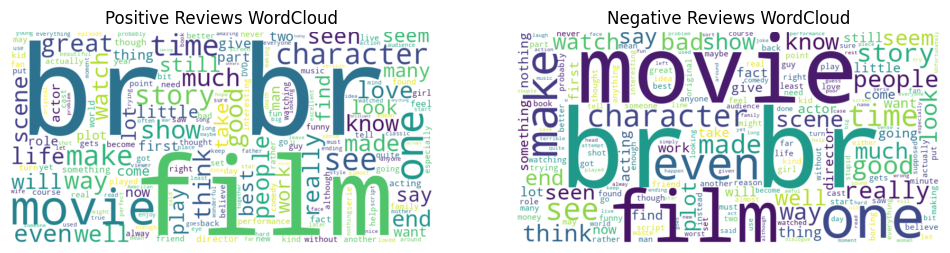

In [ ]:
# Positive wordcloud
pos_text = " ".join(data[data["sentiment"]=="positive"]["review"])
neg_text = " ".join(data[data["sentiment"]=="negative"]["review"])

wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(pos_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color="white").generate(neg_text)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews WordCloud")

plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews WordCloud")
plt.show()

In [ ]:
# Top N-grams (Bigrams/Tri) (find most frequent 2-word or 3-word phrases for each sentiment)

def get_top_ngrams(corpus, ngram_range=(2,2), n=10):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

#  top bigrams for positive
top_pos_bigrams = get_top_ngrams(data[data["sentiment"]=="positive"]["review"], (2,2))
pd.DataFrame(top_pos_bigrams, columns=["Bigram", "Frequency"])

#top bigrams for negative
top_neg_bigrams = get_top_ngrams(data[data["sentiment"]=="negative"]["review"], (2,2))
pd.DataFrame(top_neg_bigrams, columns=["Bigram", "Frequency"])

print("Top Bigrams for Positive Reviews:")
print(pd.DataFrame(top_pos_bigrams, columns=["Bigram", "Frequency"]))

print("\nTop Bigrams for Negative Reviews:")
print(pd.DataFrame(top_neg_bigrams, columns=["Bigram", "Frequency"]))


Top Bigrams for Positive Reviews:
            Bigram  Frequency
0            br br      49071
1          ve seen       1861
2          br film       1725
3         br movie       1327
4          film br        983
5         movie br        923
6         don know        899
7         new york        854
8  special effects        807
9        real life        761

Top Bigrams for Negative Reviews:
            Bigram  Frequency
0            br br      52117
1          ve seen       2307
2         br movie       1665
3       waste time       1452
4  special effects       1442
5         movie br       1435
6         don know       1302
7          br film       1282
8       looks like       1258
9       low budget       1230


#Data Processing for Linear Regression

In [39]:
#check null values
print(data.isnull().sum())
print(f"\nTotal null values: {data.isnull().sum().sum()}")

# Check data types and basic info
print("\nDataset info:")
print(data.info())

review       0
sentiment    0
dtype: int64

Total null values: 0

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None


In [40]:
# Encode sentiment labels
# Convert 'positive' to 1 and 'negative' to 0
data.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)

In [41]:
# Remove duplicates
print("Duplicates in Dataset: ",data.duplicated().sum())
data.drop_duplicates(inplace = True)

Duplicates in Dataset:  4


In [42]:
# Convert reviews to lowercase
data['review'] = data['review'].str.lower()

In [43]:
# Remove HTML tags from reviews
def remove_html_tags(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

data['review'] = data['review'].apply(remove_html_tags)

In [44]:
# Remove stopwords from reviews
nltk.download('stopwords')
# Initialize Stopwords
stop_words = set(stopwords.words('english'))

# Apply Stopwords removal
data['review'] = data['review'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
# Remove URLs from reviews
data['review'] = data['review'].str.replace(r'http\S+|www\.\S+', '', case=False)

In [46]:
# Prepare data for Logistic Regression
A = data['review']  # Features (text reviews)
B = data['sentiment']  # Target labels (0 for negative, 1 for positive)

In [47]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(A, B, test_size=0.2, random_state=42)

In [14]:
# Transform text data using TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [49]:
print(len(X_train), len(Y_train))  # should be equal
print(len(X_test), len(Y_test))    # should be equal


39662 39662
9916 9916


## Training logistic_Regression

In [31]:
# Train Logistic Regression model

def train_logistic_regression(X_train, y_train, **kwargs):
    """
    Parameters:
        X_train: Training features
        y_train: Training labels
        **kwargs: Optional hyperparameters for LogisticRegression
    """
    # Use defaults if no kwargs are provided
    params = {"max_iter": 500, "verbose": 1}
    params.update(kwargs)

    log_reg = LogisticRegression(**params)
    log_reg.fit(X_train, y_train)

    return log_reg

In [37]:
logistic_regression_model_1 = train_logistic_regression(X_train_tfidf, Y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished


## Evaluate Model Performance/Make predictions

In [65]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, x_test, y_test, model_name="Model"):
    """
    Parameters:
        model: Trained ML model
        X_test: Test features
        y_test: True labels
        model_name: Name of the model (for printing purposes)
    """
    # Predict on test set
    y_pred = model.predict(x_test)

    # Metrics
    print(y_test.shape, x_test.shape)
    accuracy = accuracy_score(y_test, y_pred)

    """f1 = f1_score(y_test, y_pred, average='weighted')


    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(f"{model_name} F1-score: {f1:.2f}")


    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()"""


In [66]:
evaluate_model(logistic_regression_model_1, X_test_tfidf, Y_test, model_name="logistic_regression_model_1")


(9916,) (9917, 5000)


ValueError: Found input variables with inconsistent numbers of samples: [9916, 9917]

In [55]:
y_pred = logistic_regression_model_1.predict(X_test_tfidf)

# Data processing for LSTM

In [ ]:
# Tokenize text data
tokenizer = Tokenizer(num_words=5000)  # Limit vocabulary to 5000 most frequent words
tokenizer.fit_on_texts(data['review'])

# Display tokenizer information
print(f"Total words in corpus: {len(tokenizer.word_index)}")
print(f"Vocabulary size (limited to): {min(len(tokenizer.word_index), 5000)}")

Total words in corpus: 180444
Vocabulary size (limited to): 5000


In [ ]:
# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(data['review'])

# Check sequence lengths
sequence_lengths = [len(seq) for seq in sequences]
print(f"Average sequence length: {np.mean(sequence_lengths):.2f}")
print(f"Maximum sequence length: {max(sequence_lengths)}")
print(f"Minimum sequence length: {min(sequence_lengths)}")

Average sequence length: 97.88
Maximum sequence length: 932
Minimum sequence length: 2


In [ ]:
# Pad sequences to ensure uniform length
max_length = 200
X_padded = pad_sequences(sequences, maxlen=max_length)

print(f"Shape of padded sequences: {X_padded.shape}")
print(f"Each sequence is now exactly {max_length} tokens long")

Shape of padded sequences: (49582, 200)
Each sequence is now exactly 200 tokens long


In [ ]:
# Prepare features and target variables
X = X_padded  # Padded sequences as features
y = data['sentiment'].values  # Target labels (0 for negative, 1 for positive)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution: {np.bincount(y)}")

Features shape: (49582, 200)
Target shape: (49582,)
Target distribution: [24698 24884]


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")
print(f"Training set distribution: {np.bincount(y_train)}")
print(f"Testing set distribution: {np.bincount(y_test)}")

Training set shape: X_train=(39665, 200), y_train=(39665,)
Testing set shape: X_test=(9917, 200), y_test=(9917,)
Training set distribution: [19758 19907]
Testing set distribution: [4940 4977]


# First LSTM Model
A single LSTM layer on top of word embeddings, with dropout regularization, optimized with Adam for binary sentiment classification

In [ ]:
# Build the LSTM model
model_1 = Sequential()
model_1.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model_1.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_1.add(Dense(1, activation="sigmoid"))

# Display model summary
model_1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Compile & Train the Model

In [ ]:
# Compile the model
model_1.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

# Train the model
history_1 = model_1.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

## Evaluate Model Performance

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy, test_precision, test_recall = model_1.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")

Test Loss: 0.3520
Test Accuracy: 0.8777
Test Precision: 0.8839
Test Recall: 0.8706
Test F1-Score: 0.8772


## Plot Training History

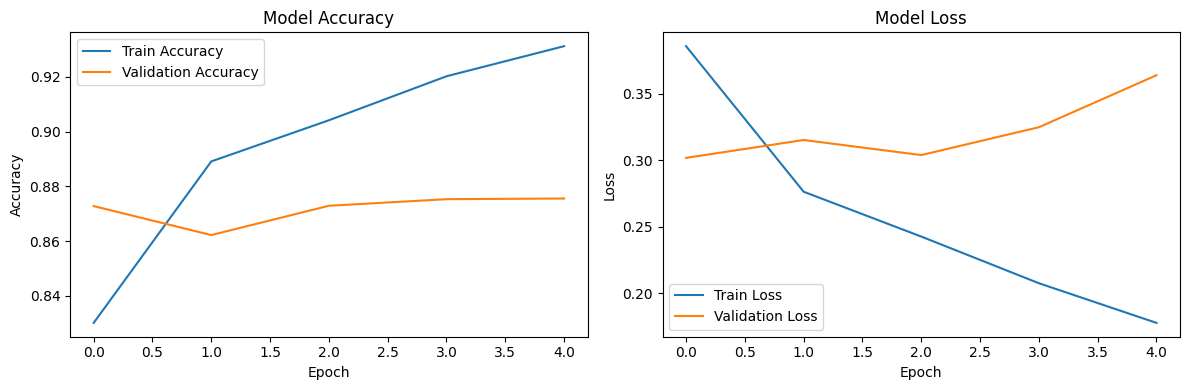

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_1.history["accuracy"], label="Train Accuracy")
plt.plot(history_1.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_1.history["loss"], label="Train Loss")
plt.plot(history_1.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Second LSTM Model
Two-layer LSTM architecture (128 → 64) with higher dropout, enabling deeper sequence representation while reducing overfitting.




In [ ]:
# Build the LSTM model
model_2 = Sequential()
model_2.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model_2.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
model_2.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model_2.add(Dense(1, activation="sigmoid"))

# Display model summary
model_2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Compile & Train the Model

In [ ]:
# Compile the model
model_2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

# Train the model
history_2 = model_2.fit(
    X_train, y_train,
    epochs=6,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/6
496/496 ━━━━━━━━━━━━━━━━━━━━ 454s 899ms/step - accuracy: 0.7586 - loss: 0.4795 - precision_3: 0.7621 - recall_3: 0.7407 - val_accuracy: 0.8756 - val_loss: 0.3046 - val_precision_3: 0.8670 - val_recall_3: 0.8881
Epoch 2/6
496/496 ━━━━━━━━━━━━━━━━━━━━ 446s 899ms/step - accuracy: 0.8850 - loss: 0.2888 - precision_3: 0.8859 - recall_3: 0.8849 - val_accuracy: 0.8673 - val_loss: 0.3178 - val_precision_3: 0.8417 - val_recall_3: 0.9055
Epoch 3/6
496/496 ━━━━━━━━━━━━━━━━━━━━ 502s 898ms/step - accuracy: 0.8989 - loss: 0.2561 - precision_3: 0.8979 - recall_3: 0.9011 - val_accuracy: 0.8658 - val_loss: 0.3627 - val_precision_3: 0.9069 - val_recall_3: 0.8159
Epoch 4/6
496/496 ━━━━━━━━━━━━━━━━━━━━ 502s 899ms/step - accuracy: 0.9155 - loss: 0.2199 - precision_3: 0.9110 - recall_3: 0.9226 - val_accuracy: 0.8768 - val_loss: 0.3115 - val_precision_3: 0.8536 - val_recall_3: 0.9105
Epoch 5/6
496/496 ━━━━━━━━━━━━━━━━━━━━ 442s 889ms/step - accuracy: 0.9241 - loss: 0.1985 - precision_3: 0.9231 - rec

## Evaluate Model Performance

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy, test_precision, test_recall = model_2.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")

Test Loss: 0.3292
Test Accuracy: 0.8790
Test Precision: 0.8764
Test Recall: 0.8835
Test F1-Score: 0.8799


## Plot Training History

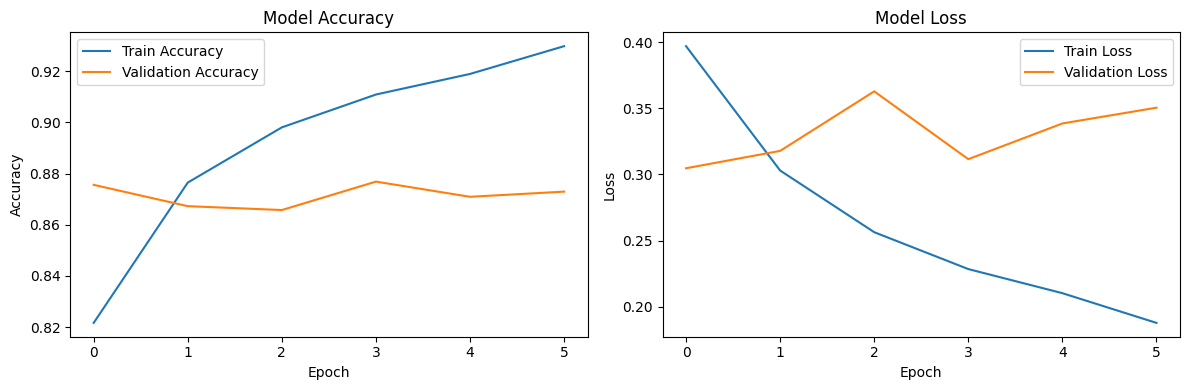

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_2.history["accuracy"], label="Train Accuracy")
plt.plot(history_2.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_2.history["loss"], label="Train Loss")
plt.plot(history_2.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Third LSTM Model (BEST)
A bidirectional LSTM capturing context in both directions, followed by a dense layer for richer feature learning.

In [ ]:
# Build the LSTM model
model_3 = Sequential()
model_3.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model_3.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model_3.add(Dense(64, activation="relu"))
model_3.add(Dropout(0.3))
model_3.add(Dense(1, activation="sigmoid"))

# Display model summary
model_3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Compile & Train the Model

In [ ]:
# Compile the model
model_3.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

# Train the model
history_3 = model_3.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - accuracy: 0.6062 - loss: 0.6269 - precision_4: 0.5965 - recall_4: 0.7290 - val_accuracy: 0.8680 - val_loss: 0.3195 - val_precision_4: 0.8747 - val_recall_4: 0.8599
Epoch 2/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.8705 - loss: 0.3253 - precision_4: 0.8731 - recall_4: 0.8699 - val_accuracy: 0.8738 - val_loss: 0.3035 - val_precision_4: 0.8780 - val_recall_4: 0.8690
Epoch 3/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step - accuracy: 0.8934 - loss: 0.2747 - precision_4: 0.8931 - recall_4: 0.8946 - val_accuracy: 0.8719 - val_loss: 0.3091 - val_precision_4: 0.8512 - val_recall_4: 0.9022
Epoch 4/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/step - accuracy: 0.9042 - loss: 0.2524 - precision_4: 0.9018 - recall_4: 0.9082 - val_accuracy: 0.8794 - val_loss: 0.2913 - val_precision_4: 0.8794 - val_recall_4: 0.8801
Epoch 5/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step - accuracy: 0.9114 - loss: 0.2364 - precision_4: 0.9115 - recall_4: 0.9126 -

## Evaluate Model Performance

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy, test_precision, test_recall = model_3.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")

Test Loss: 0.2852
Test Accuracy: 0.8801
Test Precision: 0.8794
Test Recall: 0.8821
Test F1-Score: 0.8807


## Plot Training History

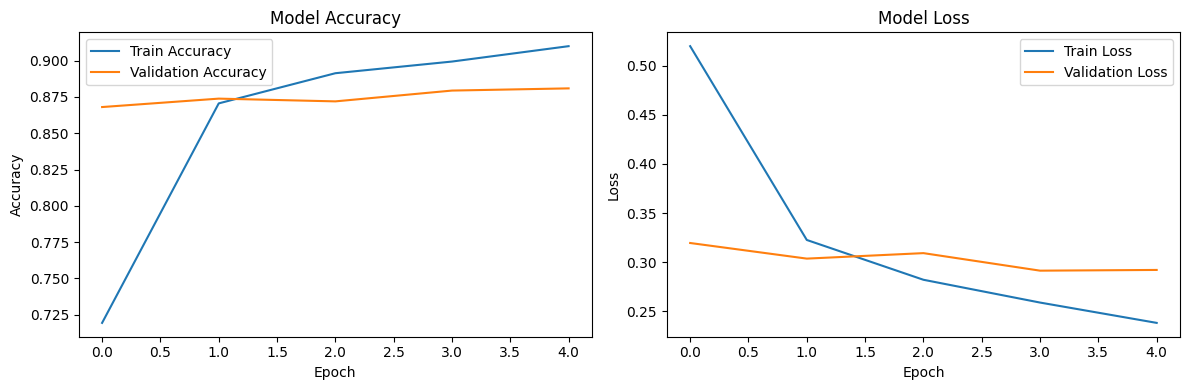

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_3.history["accuracy"], label="Train Accuracy")
plt.plot(history_3.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_3.history["loss"], label="Train Loss")
plt.plot(history_3.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()